# Rocket Control with JuMP

*This problem was drawn from the [COPS3](http://www.mcs.anl.gov/~more/cops/cops3.pdf) benchmark, and the notebook is from the [JuliaOpt notebook collection](https://github.com/JuliaOpt/juliaopt-notebooks)*

Our goal is to maximize the final altitude of a vertically launched rocket. We can control the thrust of the rocket, and must take account of the rocket mass, fuel consumption rate, gravity, and aerodynamic drag.

Let us consider the basic description of the model (for the full description, including parameters for the rocket, see the COPS3 PDF)

### Overview

We will use a discretized model of time, with a fixed number of time steps, $n$. We will make the time step size $\Delta t$, and thus the final time $t_f = n \cdot \Delta t$, a variable in the problem. To approximate the derivatives in the problem we will use the [trapezoidal rule](http://en.wikipedia.org/wiki/Trapezoidal_rule).

### State and Control

We will have three state variables:

* Velocity, $v$
* Altitude, $h$
* Mass of rocket and remaining fuel, $m$

and a single control variable, thrust $T$. Our goal is thus to maximize $h(t_f)$. Each of these corresponds to a JuMP variable indexed by the time step.

### Dynamics

We have three equations that control the dynamics of the rocket:

Rate of ascent: $$h^\prime = v$$
Acceleration: $$v^\prime = \frac{T - D(h,v)}{m} - g(h)$$
Rate of mass loss: $$m^\prime = -\frac{T}{c}$$

where drag $D(h,v)$ is a function of altitude and velocity, and gravity $g(h)$ is a function of altitude. These forces are defined as

$$D(h,v) = D_c v^2 exp\left( -h_c \left( \frac{h-h(0)}{h(0)} \right) \right)$$
and
$$g(h) = g_0 \left( \frac{h(0)}{h} \right)^2$$

The three rate equations correspond to JuMP constraints, and for convenience we will represent the forces with nonlinear expressions that we define seperately with `@defNLExpr`.

In [2]:
using JuMP, Ipopt, Interact, Gadfly

Slider{Float64}([Input{Float64}] 3.5,"T_c",3.5,1.0:0.5:6.0)

Slider{Int64}([Input{Int64}] 500,"h_c",500,300:100:700)

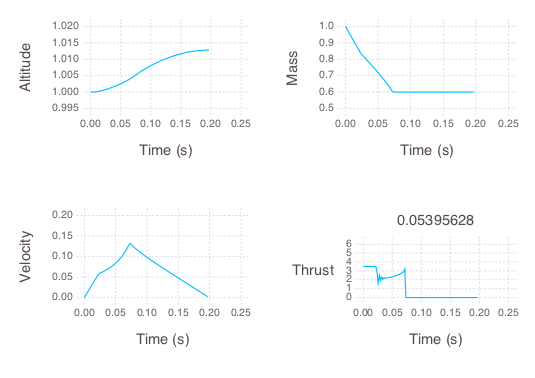

In [6]:
# Create JuMP model, using Ipopt as the solver
mod = Model(solver=IpoptSolver(print_level=0))

# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

# Parameters
T_c = 3.5  # Used for thrust
h_c_arr = [500]  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

# Derived parameters
c     = 0.5*sqrt(g_0*h_0)  # Thrust-to-fuel mass
m_f   = m_c*m_0            # Final mass
D_c   = 0.5*v_c*m_0/g_0    # Drag scaling
T_max = T_c*g_0*m_0        # Maximum thrust

n = 100   # Time steps
@defVar(mod, Δt ≥ 0, start = 1/n)   # Time step
@defNLExpr(t_f, Δt*n)               # Time of flight

# State variables
@defVar(mod, v[0:n] ≥ 0)            # Velocity
@defVar(mod, h[0:n] ≥ h_0)          # Height
@defVar(mod, m_f ≤ m[0:n] ≤ m_0)    # Mass

# Control: thrust
@defVar(mod, 0 ≤ T[0:n] ≤ T_max)

# Objective: maximize altitude at end of time of flight
@setObjective(mod, Max, h[n])

# Initial conditions
@addConstraint(mod, v[0] == v_0)
@addConstraint(mod, h[0] == h_0)
@addConstraint(mod, m[0] == m_0)
@addConstraint(mod, m[n] == m_f)

# Forces
# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@defNLExpr(drag[j=0:n], D_c*(v[j]^2)*exp(-h_c_arr[1]*(h[j]-h_0)/h_0))
# Grav(h)   = go * (h0 / h)^2
@defNLExpr(grav[j=0:n], g_0*(h_0/h[j])^2)

# Dynamics
for j in 1:n
    # h' = v
    # Rectangular integration
    # @addNLConstraint(mod, h[j] == h[j-1] + Δt*v[j-1])
    # Trapezoidal integration
    @addNLConstraint(mod,
        h[j] == h[j-1] + 0.5*Δt*(v[j]+v[j-1]))

    # v' = (T-D(h,v))/m - g(h)
    # Rectangular integration
    # @addNLConstraint(mod, v[j] == v[j-1] + Δt*(
    #                 (T[j-1] - drag[j-1])/m[j-1] - grav[j-1]))
    # Trapezoidal integration
    @addNLConstraint(mod,
        v[j] == v[j-1] + 0.5*Δt*(
            (T[j  ] - drag[j  ] - m[j  ]*grav[j  ])/m[j  ] +
            (T[j-1] - drag[j-1] - m[j-1]*grav[j-1])/m[j-1] ))

    # m' = -T/c
    # Rectangular integration
    # @addNLConstraint(mod, m[j] == m[j-1] - Δt*T[j-1]/c)
    # Trapezoidal integration
    @addNLConstraint(mod,
        m[j] == m[j-1] - 0.5*Δt*(T[j] + T[j-1])/c)
end

# Provide starting solution
for k in 0:n
    setValue(h[k], 1)
    setValue(v[k], (k/n)*(1 - (k/n)))
    setValue(m[k], (m_f - m_0)*(k/n) + m_0)
    setValue(T[k], T_max/2)
end

solve(mod)

@manipulate for T_c in 1.0:0.5:6.0, h_c in 300:100:700
    # Update parameters
    h_c_arr[1] = h_c
    T_max = T_c*g_0*m_0
    for k in 0:n
        setUpper(T[k], T_max)
    end

    # Solve for the control and state
    status = solve(mod)

    # Display results
    h_plot = plot(
    x=(0:n)*getValue(Δt),
    y=getValue(h)[1:n],
    Geom.line,
    Scale.y_continuous(minvalue=1.0, maxvalue=1.02),
    Scale.x_continuous(minvalue=0.0, maxvalue=0.25),
    Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
    
    m_plot = plot(
    x=(0:n)*getValue(Δt),
    y=getValue(m)[1:n],
    Geom.line,
    Scale.y_continuous(minvalue=0.6, maxvalue=1.0),
    Scale.x_continuous(minvalue=0.0, maxvalue=0.25),
    Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
    
    v_plot = plot(
    x=(0:n)*getValue(Δt),
    y=getValue(v)[1:n],
    Geom.line,
    Scale.y_continuous(minvalue=0.0, maxvalue=0.2),
    Scale.x_continuous(minvalue=0.0, maxvalue=0.25),
    Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
    
    T_plot = plot(
    x=(0:n)*getValue(Δt),
    y=getValue(T)[1:n],
    Geom.line,
    Scale.y_continuous(minvalue=0.0, maxvalue=6.0),
    Scale.x_continuous(minvalue=0.0, maxvalue=0.25),
    Guide.xlabel("Time (s)"),
    Guide.ylabel("Thrust"))

    vstack( hstack(h_plot,m_plot), hstack(v_plot,T_plot) )   
end